## LIANA goes to SPACE 
(Work in Progress)

### Env Set up

In [1]:
import numpy as np
import numba as nb

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import decoupler as dc

In [3]:
from mudata import MuData

In [4]:
import liana as li
from liana.method.sp import lr_basis, basis

In [5]:
from statsmodels.stats.multitest import fdrcorrection
from plotnine import theme

## Load Data

In [6]:
# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

##### Estimate squidpy proximities

In [7]:
sq.gr.spatial_neighbors(adata, n_rings=2, coord_type="grid", n_neighs=6)

In [8]:
adata.obsp["spatial_connectivities"]

<2688x2688 sparse matrix of type '<class 'numpy.float64'>'
	with 45944 stored elements in Compressed Sparse Row format>

##### Run PROGENy & Dorothea

In [9]:
model = dc.get_progeny(organism='mouse', top=1000)
model

,source,target,weight,p_value
0,Androgen,Tmprss2,11.490631,0.000000e+00
1,Androgen,Nkx3-1,10.622551,2.242078e-44
2,NFkB,Nkx3-1,2.372983,5.589476e-32
3,TGFb,Nkx3-1,1.053527,1.137010e-02
4,TNFa,Nkx3-1,2.871633,1.044050e-27
...,...,...,...,...
13784,p53,Retnlg,0.827873,6.576339e-05
13785,p53,Hsd17b3,2.445787,6.607703e-05
13786,p53,Sf3b3,-1.615436,6.641896e-05
13787,p53,Gm9008,-2.288269,6.643224e-05


In [ ]:
dc.run_mlm(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True)

# Store them in a different key
adata.obsm['progeny_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['progeny_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()
acts = dc.get_acts(adata, obsm_key='progeny_mlm_estimate')
acts
acts.write_h5ad('progeny_acts.h5ad')

In [ ]:
model = dc.get_dorothea(organism='mouse')

In [ ]:
dc.run_mlm(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True)

# Store them in a different key
adata.obsm['dorothea_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['dorothea_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()

In [ ]:
acts.write_h5ad('dorothea_acts.h5ad')

#### Build MuData

In [10]:
progeny = sc.read_h5ad('progeny_acts.h5ad')
dorothea = sc.read_h5ad('dorothea_acts.h5ad')

mdata = MuData({"expr": adata, 'progeny': progeny, 'dorothea': dorothea})

# Transfer the spatial coordinates to the MuData object
mdata.uns = adata.uns

/home/dbdimitrov/anaconda3/envs/liana-py/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.


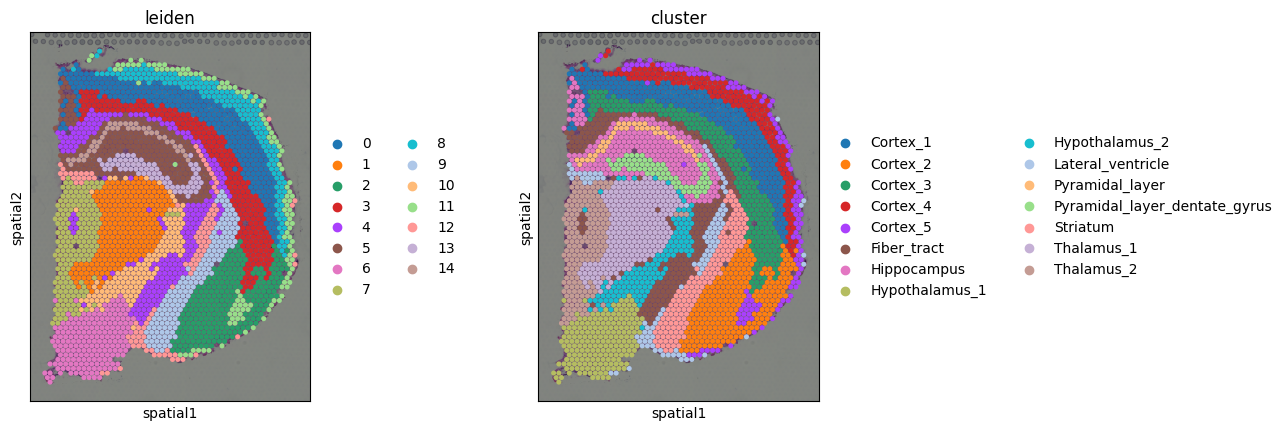

In [11]:
sc.pl.spatial(adata, color=['leiden', 'cluster'], cmap='coolwarm', size=1.5, wspace=0)

Calculate spot to spot proximities

In [12]:
# transfer coordinates
mdata.obsm["spatial"] = adata.obsm["spatial"]
mdata.obsp = adata.obsp

In [13]:
li.mt.get_spatial_proximity(adata=mdata, parameter=200, bypass_diagonal=False, cutoff=0.2)

In [14]:
# transfer proximities to expr obj
mdata.mod['expr'].obsp['proximity'] = mdata.obsp['proximity']

In [15]:
mdata.obsp

PairwiseArrays with keys: connectivities, distances, spatial_connectivities, spatial_distances, proximity

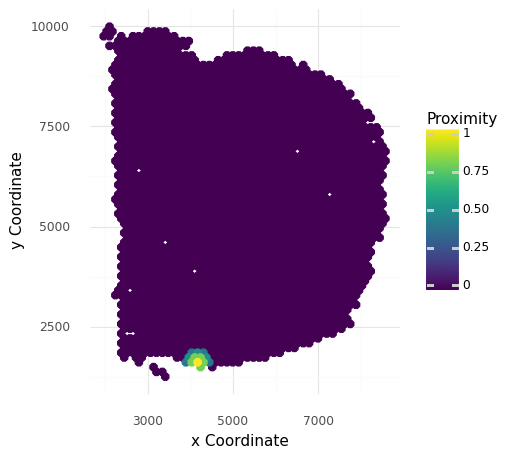

<ggplot: (8729080790587)>

In [16]:
my_p = li.pl.proximity_plot(mdata, idx=1, spatial_key='spatial', proximity_key='proximity')
(my_p + theme(figure_size=(4, 5)))

Run SpatialDM (i.e. Ligand-Recepto spatial inference)

In [17]:
lr_basis(mdata.mod['expr'],
         function_name="morans",
         expr_prop=0.1,
         resource_name="MouseConsensus",
         pvalue_method="analytical", 
         use_raw=False,
         positive_only=True)

In [18]:
mdata.mod['expr'].obsm['local_scores']

interaction,Adam10&Notch1,Adam17&Notch1,Dlk1&Notch1,Cntn1&Notch1,Dlk2&Notch1,Dll3&Notch1,Jag2&Notch1,Mfap2&Notch1,Wnt4&Notch1,Ybx1&Notch1,...,Nptx2&Nptxr,Nptx1&Nptxr,S100a1&Trpm3,Arf6&Pld1,Arf6&Smap1,P4hb&Mttp,Gad1&Grm4,Rims1&Slc17a7,Nucb2&Erap1,Fstl5&Sdk2
AAACAAGTATCTCCCA-1,0.010566,-0.005008,-0.009793,0.028067,-0.011548,-0.004492,-0.011326,-0.003515,-0.014399,-0.000996,...,5.296849,-0.469596,-0.007994,0.085718,0.367250,-0.054576,0.038631,0.655277,0.034590,0.066138
AAACAATCTACTAGCA-1,0.107707,0.020903,0.040871,-0.125635,0.048197,0.018748,0.047268,0.014672,0.060097,-0.041162,...,-0.333785,-0.953766,-0.041640,-0.113776,-0.151008,0.063393,-0.606363,1.615395,0.011392,0.031756
AAACACCAATAACTGC-1,-0.005344,-0.036284,0.222971,-0.108802,-0.083662,-0.032544,-0.082050,-0.025468,-0.104319,-0.033340,...,0.493210,1.409312,0.008477,0.017106,0.152416,0.014074,0.010309,1.953347,-0.048855,0.168745
AAACAGAGCGACTCCT-1,0.037008,-0.011973,-0.023411,-0.180910,0.071096,-0.010739,-0.027075,-0.008404,-0.034423,0.088461,...,-0.591261,-1.689485,-0.014929,-0.013373,0.198820,0.103090,-0.239410,-0.783707,-0.008127,0.045444
AAACCGGGTAGGTACC-1,0.058890,-0.019090,0.060137,-0.026130,0.113238,-0.017122,-0.043168,-0.013399,0.145623,-0.014549,...,-0.450637,0.764928,-0.001465,0.006006,-0.266237,-0.024379,-2.065195,0.698792,0.015181,0.150511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,-0.032631,0.375793,-0.192303,-0.325873,-0.226771,-0.088213,-0.222401,-0.069034,0.191383,0.511652,...,0.164111,-0.076819,0.228476,-0.073511,-0.399913,0.046856,-0.061679,0.008388,-0.000361,0.014763
TTGTTTCACATCCAGG-1,0.054542,-0.031277,-0.125115,0.037187,-0.017456,0.009494,0.023936,0.007430,0.030433,0.119247,...,-0.752134,0.002136,0.127265,0.020599,0.038744,0.016179,0.036269,-0.702113,-0.045080,0.017277
TTGTTTCATTAGTCTA-1,0.109074,0.021168,-0.089616,0.022964,0.048808,-0.112019,-0.083138,0.014858,0.060859,0.033409,...,0.450393,1.286965,0.008621,-0.003272,-0.123564,0.012288,-0.429087,2.407804,0.010676,-0.384998
TTGTTTCCATACAACT-1,0.012002,0.102170,-0.042455,0.044163,-0.050064,-0.019475,-0.049100,-0.015241,0.309812,-0.244608,...,0.798691,2.282200,0.008519,-0.006301,-0.077161,0.013231,-0.995352,-0.580295,-0.014447,-0.012072


In [19]:
# save results as modalities
mdata.mod['local_lr']  = li.fun.obsm_to_adata(mdata.mod['expr'], 'local_scores')
mdata.mod['local_pvals'] = li.fun.obsm_to_adata(mdata.mod['expr'], 'local_pvals')

### Show results

Global Moran's I

In [20]:
global_morans = mdata.mod['expr'].uns['global_res'].sort_values('global_r')

In [21]:
global_morans

,ligand,receptor,ligand_means,ligand_props,receptor_means,receptor_props,interaction,global_r,global_pvals
2852,Gnai2,Adcy1,1.626721,0.966518,1.519379,0.898438,Gnai2&Adcy1,-0.279566,1.0
2292,Agt,Mas1,1.153787,0.687128,0.136406,0.172619,Agt&Mas1,-0.250330,1.0
2786,Lgi3,Stx1a,1.376733,0.897693,1.109148,0.718750,Lgi3&Stx1a,-0.232977,1.0
2544,Apoe,Sorl1,4.075930,1.000000,1.021082,0.803199,Apoe&Sorl1,-0.221719,1.0
2983,Gad1,Grm4,1.216953,0.765997,0.246194,0.273065,Gad1&Grm4,-0.219241,1.0
...,...,...,...,...,...,...,...,...,...
2898,Rtn4,Lingo1,2.446542,0.992188,1.553612,0.893601,Rtn4&Lingo1,0.228916,0.0
2523,Cck,Cckbr,2.622576,0.947917,0.295722,0.344494,Cck&Cckbr,0.247039,0.0
1254,Sema4d,Plxnb3,0.544131,0.524554,0.190867,0.219866,Sema4d&Plxnb3,0.250838,0.0
2986,Rims1,Slc17a7,0.628196,0.638393,2.257496,0.891741,Rims1&Slc17a7,0.295771,0.0


In [22]:
from statsmodels.stats.multitest import fdrcorrection

In [23]:
_, fdr = fdrcorrection(global_morans['global_pvals'])

In [30]:
global_morans['fdr'] = fdr
sig_lrs = global_morans[global_morans['fdr'] <= 0.01]['interaction'].values

In [31]:
len(sig_lrs) # Too many for our purposes

356

In [32]:
mdata.mod['local_lr'].var_names

Index(['Adam10&Notch1', 'Adam17&Notch1', 'Dlk1&Notch1', 'Cntn1&Notch1',
       'Dlk2&Notch1', 'Dll3&Notch1', 'Jag2&Notch1', 'Mfap2&Notch1',
       'Wnt4&Notch1', 'Ybx1&Notch1',
       ...
       'Nptx2&Nptxr', 'Nptx1&Nptxr', 'S100a1&Trpm3', 'Arf6&Pld1', 'Arf6&Smap1',
       'P4hb&Mttp', 'Gad1&Grm4', 'Rims1&Slc17a7', 'Nucb2&Erap1', 'Fstl5&Sdk2'],
      dtype='object', name='interaction', length=830)

Local Moran's I

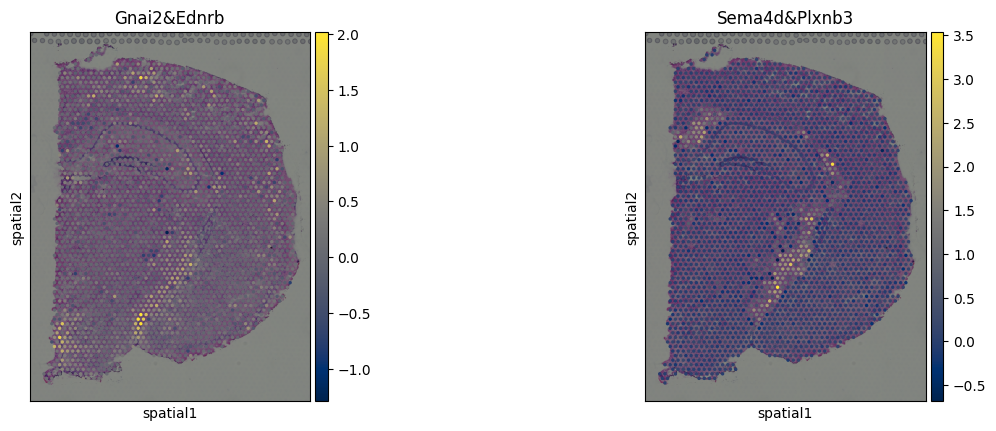

In [33]:
sc.pl.spatial(mdata.mod['local_lr'], color=['Gnai2&Ednrb', 'Sema4d&Plxnb3'], cmap='cividis')

P-values (Geometric permutation test)

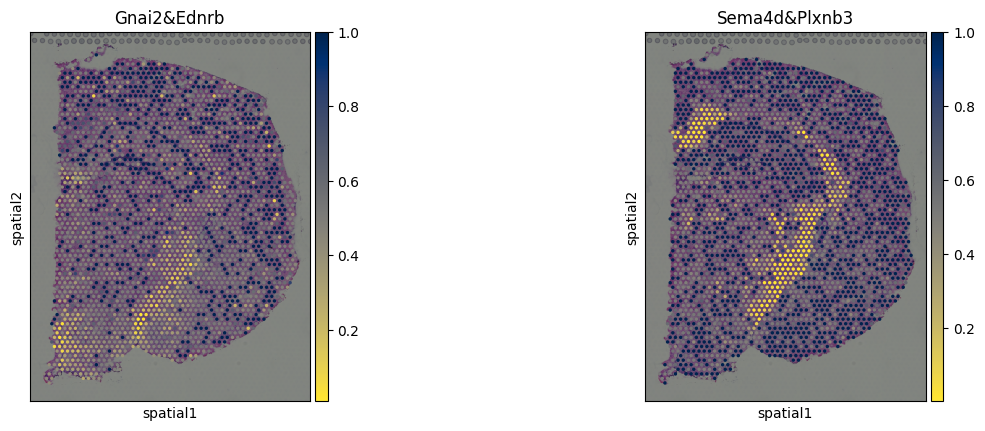

In [34]:
sc.pl.spatial(mdata.mod['local_pvals'], color=['Gnai2&Ednrb', 'Sema4d&Plxnb3'], cmap='cividis_r')

Expression of genes in the spatially inferred ligand-receptor pairs

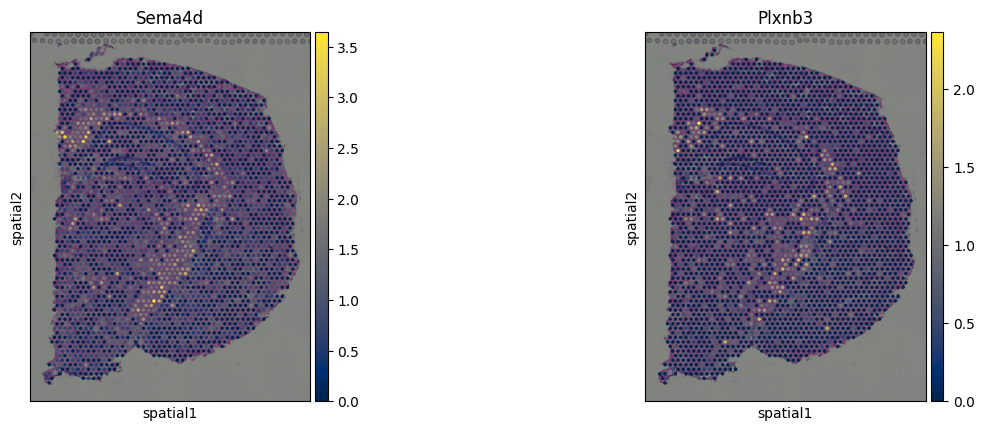

In [35]:
sc.pl.spatial(adata, color=['Sema4d', 'Plxnb3'], use_raw=False, cmap='cividis')

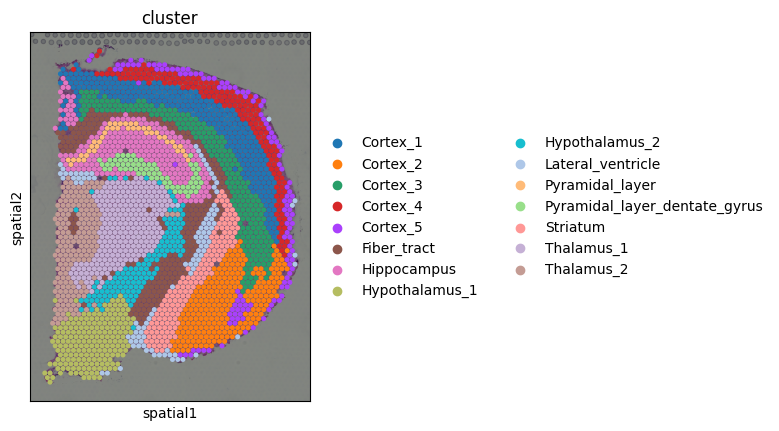

In [36]:
sc.pl.spatial(adata, color=['cluster'], cmap='coolwarm', size=1.5, wspace=0)

Cut down for computation speed

In [37]:
mdata.mod['trunc_lr'] = mdata.mod['local_lr'][:, mdata['local_lr'].var_names.str.contains("Plxnb3|Sema4d|Gnai2")].copy()

In [38]:
mdata.mod['trunc_lr']

AnnData object with n_obs × n_vars = 2688 × 24
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'spatial_neighbors', 'global_res'
    obsm: 'X_pca', 'X_umap', 'spatial', 'local_scores', 'local_pvals'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances', 'proximity'

### LR x Dorothea

Pearson Correlation

In [39]:
basis(mdata,
      function_name = "pearson",
      x_mod = 'trunc_lr', 
      y_mod = 'dorothea',
      proximity_key = 'spatial_connectivities',
      )

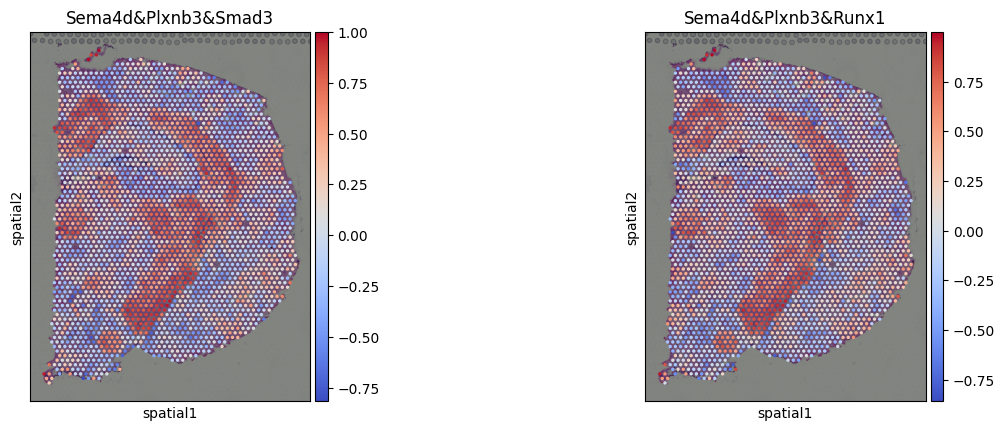

In [40]:
sc.pl.spatial(mdata.mod['local_scores'], color=['Sema4d&Plxnb3&Smad3', 'Sema4d&Plxnb3&Runx1'], cmap='coolwarm')

SpatialDM's Moran's I

In [41]:
basis(mdata,
      function_name = "morans",
      x_mod = 'trunc_lr', 
      y_mod = 'dorothea',
      proximity_key = 'proximity'
      )

/home/dbdimitrov/Repos/liana-py/liana/method/sp/_spatial_utils.py:442: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


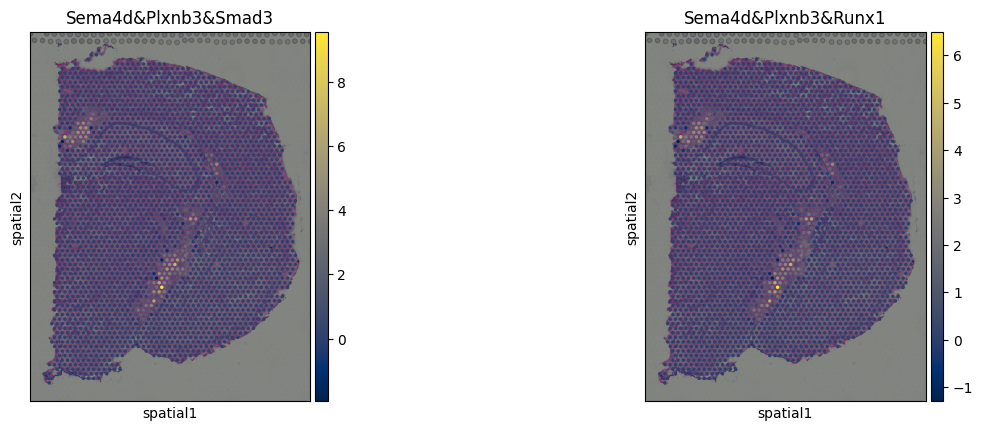

In [42]:
sc.pl.spatial(mdata.mod['local_scores'], color=['Sema4d&Plxnb3&Smad3', 'Sema4d&Plxnb3&Runx1'], cmap='cividis')

Jaccard on Positive Values

In [ ]:
basis(mdata,
      function_name = "jaccard",
      x_mod = 'trunc_lr', 
      y_mod = 'dorothea',
      proximity_key = 'proximity',
      add_categories=True,
      mod_added = 'lr_x_dorothea'
      )

In [ ]:
mdata

In [ ]:
# How to prioritize?
mdata.uns['global_res'].sort_values('global_sd', ascending=False)

In [ ]:
sc.pl.spatial(mdata.mod['lr_x_dorothea'], color=['Sema4d&Plxnb3&Smad3', 'Sema4d&Plxnb3&Runx1'], cmap='cividis')

Interaction types

In [ ]:
mdata

In [ ]:
sc.pl.spatial(mdata.mod['local_categories'], color=['Sema4d&Plxnb3&Smad3', 'Sema4d&Plxnb3&Runx1'], cmap='coolwarm')

### Relevance

- Would enable factorization of spatially-informed ligand-receptor (x-y) relationships in space
- Connects Single-cell to Spatial
- Connects to all the planned/implemented liana developments

### Feedback

 - How to reduce x,y demensionality? For efficiency.

 - What would be a useful testcase? Any dataset suggestions
 
 - Building on top of this /w Tensor/MOFA

 - Building on top of this /w misty

 - More scoring functions?


